In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import gym
import argparse
import numpy as np
from ns3gym import ns3env
from DQN_model import DeepQNetwork
from DQN_model import Eval_Model
from DQN_model import Target_Model
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
learning_rate = 0.01
reward_decay = 0.9
e_greedy = 0.9
replace_target_iter = 100
memory_size = 500
batch_size = 32
training_episodes = 50
testing_episodes = 10
max_choice = 3
training_repeat_chosen = []
testing_repeat_chosen = []
episode_time = 300
eval_model_path = ''#'/workspace/model/eval_model'
target_model_path = ''#'/workspace/model/target_model'

In [3]:
#env = gym.make('ns3-v0')
env = ns3env.Ns3Env(debug=True)

#env.reset()

ob_space = env.observation_space
ac_space = env.action_space
ob_space_n = ob_space['slotUsedTable'].shape[0] + ob_space['pktBytes'].shape[0] - 1
n_slotUsedTable = ob_space['slotUsedTable'].shape[0]


print("Observation space: ", ob_space,  ob_space.dtype)
print("Action space: ", ac_space, ac_space.dtype)
print("n_action: ",ac_space.shape[0])

Got new port for ns3gm interface:  8565
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=8565 --simSeed=2038796977"
Started ns3 simulation script, Process Id:  14888
Observation space:  Dict(pktBytes:Box(4,), slotUsedTable:Box(32,)) None
Action space:  Box(32,) int64
n_action:  32


In [4]:
try:
    eval_model = tf.keras.models.load_model(eval_model_path)
    target_model = tf.keras.models.load_model(target_model_path)
    print('load model')
except:
    eval_model = Eval_Model(num_actions=ac_space.shape[0])
    target_model = Target_Model(num_actions=ac_space.shape[0])
    print('Create new model')
RL = DeepQNetwork(ac_space.shape[0], max_choice, ob_space_n,
                  eval_model, target_model, learning_rate, reward_decay, e_greedy, 
                  replace_target_iter, memory_size, batch_size)

Create new model


In [5]:
def slot_select(q_values,choosable_slotNum):
    action_unsort = np.argpartition(q_values,-max_choice)[-max_choice:]
    action = action_unsort[np.argsort(q_values[action_unsort])]
    
    max_choosable_slotNum = min(choosable_slotNum, max_choice)
    # Using the queuing bytes to decide how many data slot would be choose
    action_num = 0 if queueBytes == 0 else min(max(0, int(queueBytes/6250 - 0.3)) + 1, max_choosable_slotNum)
        
    action[action_num:] = [-1] * (max_choice-action_num)
    
    # sort action num
    action[:action_num] = np.sort(action[:action_num])
    
    return action

In [6]:
for episode in range(training_episodes):

    isTraining = True if (episode+1)%10 != 0 else False
    if isTraining:
        print ("-----------------------episodes: ", episode, " (Training)----------------------")
    else:
        print ("-----------------------episodes: ", episode, " (Testing)-----------------------")

    stepIdx = 0
    repeat_chosen_counter = 0
    
    _obs = env.reset()
    queueBytes = _obs[1][0]
    
    choosable_slotNum = min(n_slotUsedTable - np.nonzero(_obs[0])[0].size,max_choice)
    
    _obs = np.array(list(_obs[0]) + list(_obs[1][1:]))
    _obs = np.pad(_obs,(0, ob_space_n - _obs.size), constant_values = 0)

    
    while True:
        stepIdx += 1

        action = np.array(slot_select(RL.choose_action(_obs, isTraining),choosable_slotNum))

        
        #print("---action: ", action)
        obs, reward, done, info = env.step(action)

        
        if info == "TimeOut":
            print("Step: ", stepIdx)
            print ("Repeat_chosen_counter :", repeat_chosen_counter)
            
            if isTraining:
                RL.learn()
                testing_repeat_chosen.append(repeat_chosen_counter)
            else:
                training_repeat_chosen.append(repeat_chosen_counter)
                
            break
        
        choosable_slotNum = min(n_slotUsedTable - np.nonzero(obs[0])[0].size,max_choice)
        
        # Get queuing bytes
        queueBytes = obs[1][0]
        
        # Since there are multiple action in one step,
        # according to each action, it would have one reward.
        # But in ns3gym, the reward type is float, it means it can only return one reward,
        # we use the return info to send multiple reward
        
        reward_all = [float(r) for r in info.split(',')]
        info = stepIdx
         
        
        #print("Step: ", stepIdx)
        #print("---obs, reward, done, info: ", obs, reward_all, done, info)
        
        obs = np.array(list(obs[0]) + list(obs[1][1:]),dtype=float)
        obs = np.pad(obs,(0, ob_space_n - obs.size), constant_values = 0)
        obs[n_slotUsedTable:] = obs[n_slotUsedTable:]/queueBytes if queueBytes != 0 else np.zeros(3)
        
        top_index = []
        for i in range(3):
            top_index.append(np.ravel(np.argwhere(_obs[:n_slotUsedTable]==i+1)))
        
        for act, r in zip(action,reward_all):
            if act == -1:
                continue
               
            if (act not in np.nonzero(_obs[:n_slotUsedTable])[0]):
                r += 1
            
                # Add optimized reward
                for i in range(3):
                    if any(act < idx for idx in top_index[i]):
                        distance_map = top_index[i] - act
                        closest_distance = min(np.where(distance_map>0,distance_map,np.inf))
                        distance_reward = (1.2-pow((closest_distance/10),0.1))/10
                        size_reward = _obs[-(3-i)]
                        r += (distance_reward+size_reward)
                        
                if all(idx.size == 0 for idx in top_index):
                    closest_distance = n_slotUsedTable - act
                    distance_reward = (1.2-pow((closest_distance/10),0.1))/10
                    r += distance_reward
                

            if isTraining:
                RL.store_transition(_obs, act, r, obs)
            
            if r < -5:
                repeat_chosen_counter += 1

                
        #if stepIdx % 10000 == 0:
        #    print("Step: ", stepIdx)
        
        if (stepIdx > 5000) and (stepIdx % 5 == 0) and isTraining:
            RL.learn()
            
        # swap observation
        _obs = obs
        
        
        if done or stepIdx == int(300/0.04*16):
            print("Step: ", stepIdx)
            print ("done")
            print ("Repeat_chosen_counter :", repeat_chosen_counter)
            
            if isTraining:
                RL.learn()
                testing_repeat_chosen.append(repeat_chosen_counter)
            else:
                training_repeat_chosen.append(repeat_chosen_counter)
                
            break
            
        #break
        


-----------------------episodes:  0  (Training)----------------------
Step:  120000
done
Repeat_chosen_counter : 11374
-----------------------episodes:  1  (Training)----------------------
Got new port for ns3gm interface:  7662
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=7662 --simSeed=493075150"
Started ns3 simulation script, Process Id:  18760
Step:  120000
done
Repeat_chosen_counter : 15839
-----------------------episodes:  2  (Training)----------------------
Got new port for ns3gm interface:  7707
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=7707 --simSeed=2654751566"
Started ns3 simulation script, Process Id:  22666
Step:  120000
done
Repeat_chosen_counter : 21722
-----------------------episodes:  3  (Training)----------------------
Got new port for ns3gm interface:  5210
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=5210 --simSeed=4025577558"
Started ns3 simulation script, Process Id:  25986
Step:  120000
done
Repeat_chosen_counter

Step:  120000
done
Repeat_chosen_counter : 49998
-----------------------episodes:  29  (Testing)-----------------------
Got new port for ns3gm interface:  8586
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=8586 --simSeed=1652412841"
Started ns3 simulation script, Process Id:  1602
Step:  120000
done
Repeat_chosen_counter : 56121
-----------------------episodes:  30  (Training)----------------------
Got new port for ns3gm interface:  7822
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=7822 --simSeed=4188102648"
Started ns3 simulation script, Process Id:  8825
Step:  120000
done
Repeat_chosen_counter : 17350
-----------------------episodes:  31  (Training)----------------------
Got new port for ns3gm interface:  8903
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=8903 --simSeed=2207602010"
Started ns3 simulation script, Process Id:  13206
Step:  120000
done
Repeat_chosen_counter : 30482
-----------------------episodes:  32  (Training)-----------

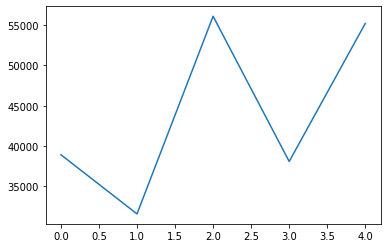

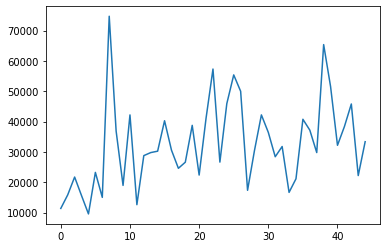

In [9]:
# step counter of each episode
plt.plot(training_repeat_chosen)
plt.show()

plt.plot(testing_repeat_chosen)
plt.show()

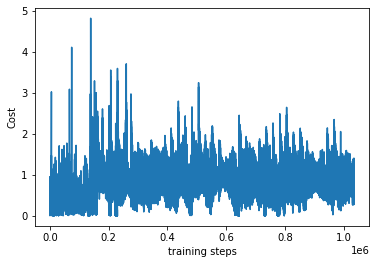

In [10]:
RL.plot_cost()

In [ ]:
env.close()

In [7]:
eval_model.save('/workspace/model/eval_model', save_format='tf')
target_model.save('/workspace/model/target_model', save_format='tf')

INFO:tensorflow:Assets written to: /workspace/model/eval_model/assets
INFO:tensorflow:Assets written to: /workspace/model/target_model/assets
